In [11]:
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from data_utils import data_preprocess
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.corpus import stopwords  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
sb.set()

In [12]:
train_df=data_preprocess('train.json')

In [13]:
dict_word_train=[]
for item in train_df['ingredients']:
    dict_word_train.append(item)

In [ ]:
all_ingredients = []
max_doc_len = -1
for i in range(train_df.shape[0]):
    token = nltk.word_tokenize(train_df['ingredients'][i])
    if(len(token)>max_doc_len):
        max_doc_len = len(token)# Get all possible ingredients
    all_ingredients.extend(token)
all_ingredients=set(all_ingredients)

In [ ]:
Max_features = len(all_ingredients)
vectorizer = CountVectorizer(max_features=Max_features, stop_words=stopwords.words('english'))  
X_train = vectorizer.fit_transform(dict_word_train).toarray()
c = train_df['cuisine'].astype('category')
Y_train=c.cat.codes
cuisine_code = dict(enumerate(c.cat.categories))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)

# Sklearn models

In [ ]:
MNB_classifier = MultinomialNB()
MNB_classifier.fit(x_train,y_train)
print("MultinomialNB_classifier accuracy percent:", (MNB_classifier.score(x_test,y_test)))

BernoulliNB_classifier = BernoulliNB()
BernoulliNB_classifier.fit(x_train,y_train)
print("BernoulliNB_classifier accuracy percent:", (BernoulliNB_classifier.score(x_test,y_test)))

LogisticRegression_classifier = LogisticRegression()
LogisticRegression_classifier.fit(x_train,y_train)
print("LogisticRegression_classifier accuracy percent:",(LogisticRegression_classifier.score(x_test,y_test)))

SGD_classifier = SGDClassifier()
SGD_classifier.fit(x_train,y_train)
print("SGD_classifier accuracy percent:", (SGD_classifier.score(x_test,y_test)))

LinearSVC_classifier = LinearSVC()
LinearSVC_classifier.fit(x_train,y_train)
print("LinearSVC_classifier accuracy percent:", (LinearSVC_classifier.score(x_test,y_test)))

MultinomialNB_classifier accuracy percent: 0.7228693538925668
BernoulliNB_classifier accuracy percent: 0.6864996228944943


C:\Users\NTU\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NTU\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression_classifier accuracy percent: 0.7697980390513701
SGD_classifier accuracy percent: 0.7656079778764769
LinearSVC_classifier accuracy percent: 0.7553004273862398


# Random Forest

In [ ]:
#control/benchmark Random Forest Classification
from sklearn import metrics
forest = RFC(n_estimators = 10, verbose = 2, n_jobs = -1)
forest.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 10building tree 1 of 10building tree 5 of 10building tree 4 of 10building tree 6 of 10building tree 7 of 10

building tree 3 of 10building tree 8 of 10





building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


Classification Accuracy 	: 0.6528953322718511


Text(111.5, 0.5, 'True Label')

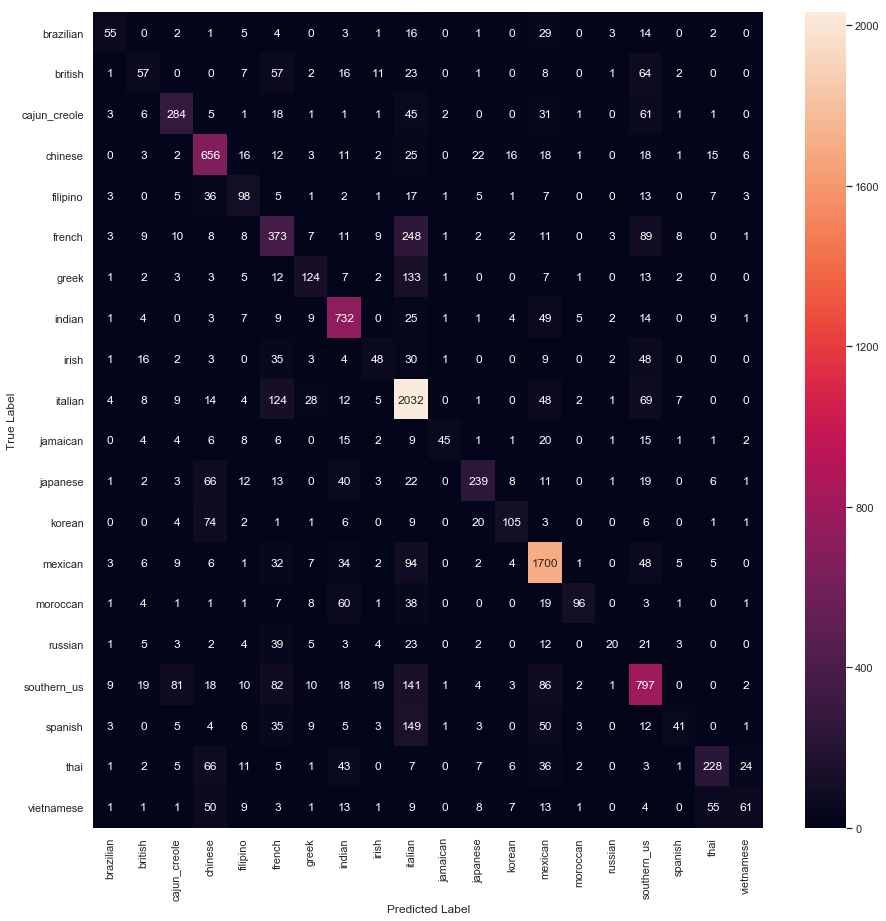

In [ ]:
#visualisation of results
labels = list(x for x in cuisine_code.values())
y_test_pred = forest.predict(x_test)
print("Classification Accuracy \t:", forest.score(x_test, y_test))
confusionMatrix_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = labels, columns = labels)
fig = plt.figure(figsize = (15,15))
sb.heatmap(confusionMatrix_df, annot = True, fmt = ".0f")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# K-fold cross validation for random forest

In [ ]:
#Takes long time to run
# create random grid for cross-validation
random_grid = {'max_features': [int(x) for x in range(10, 81, 10)],
               'max_depth': [int(x) for x in range(10, 201, 10)] + ['auto']}

#cross validation to optimise random forest
RFC_CV = RandomizedSearchCV(estimator = RFC(n_estimators = 500),
                                param_distributions = random_grid,
                                n_iter = 20,
                                cv = 5,
                                verbose = 3,
                                refit = True,
                                n_jobs = -1)
RFC_CV.fit(X_train, Y_train)

#obtain best parameters for random forest
RFC_CV.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


# Predictions for train data of each model

In [ ]:
LGR=LogisticRegression_classifier.predict(X_train)
LGR= pd.Series([cuisine_code[x] for x in LGR])
LGR = pd.DataFrame({"LGR":LGR})
MNB=MNB_classifier.predict(X_train)
MNB= pd.Series([cuisine_code[x] for x in MNB])
MNB= pd.DataFrame({"MNB":MNB})
BNB=BernoulliNB_classifier.predict(X_train)
BNB= pd.Series([cuisine_code[x] for x in BNB])
BNB= pd.DataFrame({"BNB":BNB})
SGD=SGD_classifier.predict(X_train)
SGD= pd.Series([cuisine_code[x] for x in SGD])
SGD= pd.DataFrame({"SGD":SGD})
LSVC=LinearSVC_classifier.predict(X_train)
LSVC= pd.Series([cuisine_code[x] for x in LSVC])
LSVC= pd.DataFrame({"LSVC":LSVC})
RF = forest.predict(X_train)
RF= pd.Series([cuisine_code[x] for x in RF])
RF= pd.DataFrame({"RFC":RF})
prediction = pd.concat([train_df,LGR,MNB,BNB,SGD,LSVC,RF],axis=1,sort=False)
prediction